In [1]:
import os
os.chdir('C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project1/MSDS7331_Project1')
os.getcwd()

'C:\\Users\\emrijai\\Documents\\IPython Notebooks\\MS7331\\Project1\\MSDS7331_Project1'

In [2]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

from pandas.tools.plotting import scatter_matrix

#Bring in data set
loan_df = pd.read_csv('LoanData/loanData.csv')

C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Remove unwanted attributes from the data set based on specific criteria
for col in ['id','funded_amnt_inv','sub_grade','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line',
            'mths_since_last_delinq','mths_since_last_record','pub_rec','revol_bal','revol_util','total_acc',
            'initial_list_status','out_prncp_inv','total_pymnt_inv','recoveries','collection_recovery_fee','last_pymnt_d',
            'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type',
            'annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
            'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m', 'installment', 'mths_since_last_major_derog']:
    if col in loan_df:
        del loan_df[col]

In [4]:
#Modify term to be integer for easier analysis
loan_df = loan_df.replace(to_replace=" 36 months", value=36)
loan_df = loan_df.replace(to_replace=" 60 months", value=60)

#Impute missing data values with median
for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'acc_now_delinq']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value=df_temp.median())
    loan_df[col] = df_temp
    
#Impute missing data values with median
for col in ['tot_coll_amt', 'tot_cur_bal']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp

Loan Status is divided into 3 classes of loans - Current, Bad and Good. The idea is to use the 'Bad' and 'Good' cases to train a model. The training data set from this data subset (Good+Bad) is used for train/test/validation. The reminaing data i.e. cases under status 'Current', can then be fed into the validated model to predict which loans can go 'Bad'/'Good', based on the features we have of the customers.
Bad Loans are coded = 0
Good Loans are coded = 1
Current loans are separated out into new data set for predictions later on

In [5]:
#Create new variables for classification
#Nominal classification of loan_status
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class'] = "Bad"
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class'] = "Bad"
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class'] = "Bad"
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class'] = "Bad"
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class'] = "Bad"

loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class'] = "Good"
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class'] = "Good"

loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class'] = "Current"
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class'] = "Current"
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class'] = "Current"

#Numerical classification of grade
loan_df.loc[loan_df['grade'] == 'A', 'Grade_Class'] = 1
loan_df.loc[loan_df['grade'] == 'B', 'Grade_Class'] = 2
loan_df.loc[loan_df['grade'] == 'C', 'Grade_Class'] = 3
loan_df.loc[loan_df['grade'] == 'D', 'Grade_Class'] = 4
loan_df.loc[loan_df['grade'] == 'E', 'Grade_Class'] = 5
loan_df.loc[loan_df['grade'] == 'F', 'Grade_Class'] = 6
loan_df.loc[loan_df['grade'] == 'G', 'Grade_Class'] = 7

#Numerical classification of employment length
loan_df.loc[loan_df['emp_length'] == '< 1 year', 'Emp_Class'] = 0
loan_df.loc[loan_df['emp_length'] == '1 year', 'Emp_Class'] = 1
loan_df.loc[loan_df['emp_length'] == '2 years', 'Emp_Class'] = 2
loan_df.loc[loan_df['emp_length'] == '3 years', 'Emp_Class'] = 3
loan_df.loc[loan_df['emp_length'] == '4 years', 'Emp_Class'] = 4
loan_df.loc[loan_df['emp_length'] == '5 years', 'Emp_Class'] = 5
loan_df.loc[loan_df['emp_length'] == '6 years', 'Emp_Class'] = 6
loan_df.loc[loan_df['emp_length'] == '7 years', 'Emp_Class'] = 7
loan_df.loc[loan_df['emp_length'] == '8 years', 'Emp_Class'] = 8
loan_df.loc[loan_df['emp_length'] == '9 years', 'Emp_Class'] = 9
loan_df.loc[loan_df['emp_length'] == '10+ years', 'Emp_Class'] = 10
loan_df.loc[loan_df['emp_length'] == 'n/a', 'Emp_Class'] = 0

#Nominal classification of home_ownership
loan_df.loc[loan_df['home_ownership'] == 'NONE', 'home_ownership_class'] = 'OTHER'
loan_df.loc[loan_df['home_ownership'] == 'OTHER', 'home_ownership_class'] = 'OTHER'
loan_df.loc[loan_df['home_ownership'] == 'ANY', 'home_ownership_class'] = 'OTHER'
loan_df.loc[loan_df['home_ownership'] == 'MORTGAGE', 'home_ownership_class'] = 'MORTGAGE'
loan_df.loc[loan_df['home_ownership'] == 'RENT', 'home_ownership_class'] = 'RENT'
loan_df.loc[loan_df['home_ownership'] == 'OWN', 'home_ownership_class'] = 'OWN'

#Nominal classification of verification_status
loan_df.loc[loan_df['verification_status'] == 'Verified', 'verification_status_class'] = 'V'
loan_df.loc[loan_df['verification_status'] == 'Source Verified', 'verification_status_class'] = 'SV'
loan_df.loc[loan_df['verification_status'] == 'Not Verified', 'verification_status_class'] = 'NV'

#Range of interest rates
loan_df['Int_Rate_Range'] = pd.cut(loan_df.int_rate, [0, 5,10,15,20,25, 30], 6, labels=[0,1,2,3,4,5])
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 33 columns):
member_id                    887379 non-null int64
loan_amnt                    887379 non-null float64
funded_amnt                  887379 non-null float64
term                         887379 non-null int64
int_rate                     887379 non-null float64
grade                        887379 non-null object
emp_length                   887379 non-null object
home_ownership               887379 non-null object
annual_inc                   887379 non-null float64
verification_status          887379 non-null object
issue_d                      887379 non-null object
loan_status                  887379 non-null object
desc                         126029 non-null object
purpose                      887379 non-null object
addr_state                   887379 non-null object
dti                          887379 non-null float64
delinq_2yrs                  887379 non-null float64
i

In [6]:
Int_Rate_Range = loan_df.groupby(by="Int_Rate_Range")
Int_Rate_Range.loan_amnt.count()

Int_Rate_Range
0         0
1    235621
2    372060
3    221068
4     52137
5      6493
Name: loan_amnt, dtype: int64

In [7]:
categorical = ["Loan_Class", "term", "home_ownership", "verification_status", "purpose", "addr_state", "Int_Rate_Range", "home_ownership_class","verification_status_class" ]

continuous = ["loan_amnt", "funded_amnt", "int_rate", "annual_inc", "dti", "total_pymnt", "total_rec_prncp", "total_rec_int",
             "total_rec_late_fee", "tot_coll_amt", "tot_cur_bal"]

ordinal = ["Grade_Class", "Emp_Class"]

loan_df[continuous] = loan_df[continuous].astype(np.float64)
loan_df[ordinal] = loan_df[ordinal].astype(np.int64)

loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 33 columns):
member_id                    887379 non-null int64
loan_amnt                    887379 non-null float64
funded_amnt                  887379 non-null float64
term                         887379 non-null int64
int_rate                     887379 non-null float64
grade                        887379 non-null object
emp_length                   887379 non-null object
home_ownership               887379 non-null object
annual_inc                   887379 non-null float64
verification_status          887379 non-null object
issue_d                      887379 non-null object
loan_status                  887379 non-null object
desc                         126029 non-null object
purpose                      887379 non-null object
addr_state                   887379 non-null object
dti                          887379 non-null float64
delinq_2yrs                  887379 non-null float64
i

In [8]:
#Creating the copy of the dataset with all transformed the variables retained
loan_df_copy = loan_df.copy()

In [9]:
loan_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 33 columns):
member_id                    887379 non-null int64
loan_amnt                    887379 non-null float64
funded_amnt                  887379 non-null float64
term                         887379 non-null int64
int_rate                     887379 non-null float64
grade                        887379 non-null object
emp_length                   887379 non-null object
home_ownership               887379 non-null object
annual_inc                   887379 non-null float64
verification_status          887379 non-null object
issue_d                      887379 non-null object
loan_status                  887379 non-null object
desc                         126029 non-null object
purpose                      887379 non-null object
addr_state                   887379 non-null object
dti                          887379 non-null float64
delinq_2yrs                  887379 non-null float64
i

In [10]:
# Now let's clean up the dataset. We don't need features for now.
if 'member_id' in loan_df:
    del loan_df['member_id'] # if 'member_id' column still exists, delete it. We don't need this for feature for now.
    
if 'emp_length' in loan_df:
    del loan_df['emp_length']
    
if 'verification_status' in loan_df:
    del loan_df['verification_status']
    
if 'home_ownership' in loan_df:
    del loan_df['home_ownership']
    
if 'issue_d' in loan_df:
    del loan_df['issue_d']

if 'desc' in loan_df:
    del loan_df['desc']

if 'addr_state' in loan_df:
    del loan_df['addr_state']

if 'grade' in loan_df:
    del loan_df['grade']

if 'loan_status' in loan_df:
    del loan_df['loan_status']
    
if 'loan_amnt' in loan_df:
    del loan_df['loan_amnt']

In [11]:
#Stats of nominal and continous data
loan_df.head()

,funded_amnt,term,int_rate,annual_inc,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,out_prncp,...,total_rec_late_fee,acc_now_delinq,tot_coll_amt,tot_cur_bal,Loan_Class,Grade_Class,Emp_Class,home_ownership_class,verification_status_class,Int_Rate_Range
0,5000.0,36,10.65,24000.0,credit_card,27.65,0.0,1.0,3.0,0.0,...,0.00,0.0,0.0,0.0,Good,2,10,RENT,V,2
1,2500.0,60,15.27,30000.0,car,1.00,0.0,5.0,3.0,0.0,...,0.00,0.0,0.0,0.0,Bad,3,0,RENT,SV,3
2,2400.0,36,15.96,12252.0,small_business,8.72,0.0,2.0,2.0,0.0,...,0.00,0.0,0.0,0.0,Good,3,10,RENT,NV,3
3,10000.0,36,13.49,49200.0,other,20.00,0.0,1.0,10.0,0.0,...,16.97,0.0,0.0,0.0,Good,3,10,RENT,SV,2
4,3000.0,60,12.69,80000.0,other,17.94,0.0,0.0,15.0,766.9,...,0.00,0.0,0.0,0.0,Current,2,1,RENT,SV,2


In [12]:
loan_df_copy.head()

,member_id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,total_rec_late_fee,acc_now_delinq,tot_coll_amt,tot_cur_bal,Loan_Class,Grade_Class,Emp_Class,home_ownership_class,verification_status_class,Int_Rate_Range
0,1296599,5000.0,5000.0,36,10.65,B,10+ years,RENT,24000.0,Verified,...,0.00,0.0,0.0,0.0,Good,2,10,RENT,V,2
1,1314167,2500.0,2500.0,60,15.27,C,< 1 year,RENT,30000.0,Source Verified,...,0.00,0.0,0.0,0.0,Bad,3,0,RENT,SV,3
2,1313524,2400.0,2400.0,36,15.96,C,10+ years,RENT,12252.0,Not Verified,...,0.00,0.0,0.0,0.0,Good,3,10,RENT,NV,3
3,1277178,10000.0,10000.0,36,13.49,C,10+ years,RENT,49200.0,Source Verified,...,16.97,0.0,0.0,0.0,Good,3,10,RENT,SV,2
4,1311748,3000.0,3000.0,60,12.69,B,1 year,RENT,80000.0,Source Verified,...,0.00,0.0,0.0,0.0,Current,2,1,RENT,SV,2


In [13]:
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(loan_df.home_ownership_class,prefix='HOC')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(loan_df.verification_status_class,prefix='VSC')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(loan_df.purpose,prefix='Loan_Purpose')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

In [14]:
loan_df[['home_ownership_class','verification_status_class', 'purpose', 'Loan_Class', 'Int_Rate_Range']].describe().transpose()

,count,unique,top,freq
home_ownership_class,887379,4,MORTGAGE,443557
verification_status_class,887379,3,SV,329558
purpose,887379,14,debt_consolidation,524215
Loan_Class,887379,3,Current,616492
Int_Rate_Range,887379,5,2,372060


In [15]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 44 columns):
funded_amnt                        887379 non-null float64
term                               887379 non-null int64
int_rate                           887379 non-null float64
annual_inc                         887379 non-null float64
purpose                            887379 non-null object
dti                                887379 non-null float64
delinq_2yrs                        887379 non-null float64
inq_last_6mths                     887379 non-null float64
open_acc                           887379 non-null float64
out_prncp                          887379 non-null float64
total_pymnt                        887379 non-null float64
total_rec_prncp                    887379 non-null float64
total_rec_int                      887379 non-null float64
total_rec_late_fee                 887379 non-null float64
acc_now_delinq                     887379 non-null float64
tot_col

In [16]:
#Remove the redundant variables
if 'home_ownership_class' in loan_df:
    del loan_df['home_ownership_class']
    
if 'verification_status_class' in loan_df:
    del loan_df['verification_status_class']
    
if 'purpose' in loan_df:
    del loan_df['purpose']

In [17]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 41 columns):
funded_amnt                        887379 non-null float64
term                               887379 non-null int64
int_rate                           887379 non-null float64
annual_inc                         887379 non-null float64
dti                                887379 non-null float64
delinq_2yrs                        887379 non-null float64
inq_last_6mths                     887379 non-null float64
open_acc                           887379 non-null float64
out_prncp                          887379 non-null float64
total_pymnt                        887379 non-null float64
total_rec_prncp                    887379 non-null float64
total_rec_int                      887379 non-null float64
total_rec_late_fee                 887379 non-null float64
acc_now_delinq                     887379 non-null float64
tot_coll_amt                       887379 non-null float64
tot_cu

In [18]:
loan_df_Current = loan_df[loan_df['Loan_Class'] == 'Current']
loan_df_Historical = loan_df[(loan_df['Loan_Class'] == 'Bad') | (loan_df['Loan_Class']=='Good')]

In [19]:
loan_df_Historical.shape

(270887, 41)

In [20]:
loan_df_Current.shape

(616492, 41)

In [21]:
#Assigining the labels to Good and Bad loans
#Good = 1 and Bad = 0

loan_df_Historical['IsGoodLoan'] = loan_df_Historical.Loan_Class == 'Good' 
loan_df_Historical.IsGoodLoan = loan_df_Historical.IsGoodLoan.astype(np.int)

loan_df_Historical.info()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<class 'pandas.core.frame.DataFrame'>
Int64Index: 270887 entries, 0 to 887371
Data columns (total 42 columns):
funded_amnt                        270887 non-null float64
term                               270887 non-null int64
int_rate                           270887 non-null float64
annual_inc                         270887 non-null float64
dti                                270887 non-null float64
delinq_2yrs                        270887 non-null float64
inq_last_6mths                     270887 non-null float64
open_acc                           270887 non-null float64
out_prncp                          270887 non-null float64
total_pymnt                        270887 non-null float64
total_rec_prncp                    270887 non-null float64
total_rec_int                      270887 non-null float64
total_rec_late_fee                 270887 non-null float64
acc_now_delinq                     270887 non-null float64
tot_coll_amt                       270887 non-null float64
tot_cu

In [22]:
#Delete Loan_Class as its now encoded into 0/1 (IsGoodLoan) variable
if 'Loan_Class' in loan_df_Historical:
    del loan_df_Historical['Loan_Class']

Using the hitorical data frame we can train the model.
Splitting this dataframe for training and testing

In [23]:
from sklearn.cross_validation import ShuffleSplit

# we want to predict the X and y data as follows:
if 'IsGoodLoan' in loan_df_Historical:
    y = loan_df_Historical['IsGoodLoan'].values # get the labels we want
    del loan_df_Historical['IsGoodLoan'] # get rid of the class label
    X = loan_df_Historical.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print cv_object

ShuffleSplit(270887, n_iter=3, test_size=0.2, random_state=None)


# Logistic Regression
Now let's use Logistic Regression from scikit-learn

In [24]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print "====Iteration",iter_num," ===="
    print "accuracy", acc 
    print "confusion matrix\n",conf
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.992266233527
confusion matrix
[[12039   346]
 [   73 41720]]
====Iteration 1  ====
accuracy 0.992229318173
confusion matrix
[[11969   341]
 [   80 41788]]
====Iteration 2  ====
accuracy 0.992580014028
confusion matrix
[[11841   328]
 [   74 41935]]


In [25]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print 'accuracy:', acc 
print conf
print 

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,loan_df_Historical.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print name, 'has weight of', coef[0] # now print them out

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


accuracy: 0.987559526007
[[11582   587]
 [   87 41922]]

Loan_Purpose_renewable_energy has weight of -0.00219607027675
HOC_OTHER has weight of -0.0024845380716
Loan_Purpose_educational has weight of -0.00297150531645
Loan_Purpose_home_improvement has weight of -0.00320692333126
open_acc has weight of -0.00341214407751
Loan_Purpose_house has weight of -0.00363275108989
Loan_Purpose_vacation has weight of 0.0041602983625
Loan_Purpose_wedding has weight of 0.00602202527043
Loan_Purpose_moving has weight of -0.00640140385213
Emp_Class has weight of 0.00646851025205
HOC_RENT has weight of 0.00768317102832
VSC_NV has weight of -0.00857917369729
Loan_Purpose_debt_consolidation has weight of -0.0111877262427
HOC_OWN has weight of 0.0114578352159
Loan_Purpose_medical has weight of -0.0118974409628
Loan_Purpose_other has weight of -0.0137314850066
HOC_MORTGAGE has weight of -0.013930895827
Loan_Purpose_car has weight of 0.0145811573754
acc_now_delinq has weight of 0.0199903140155
Loan_Purpose_cr

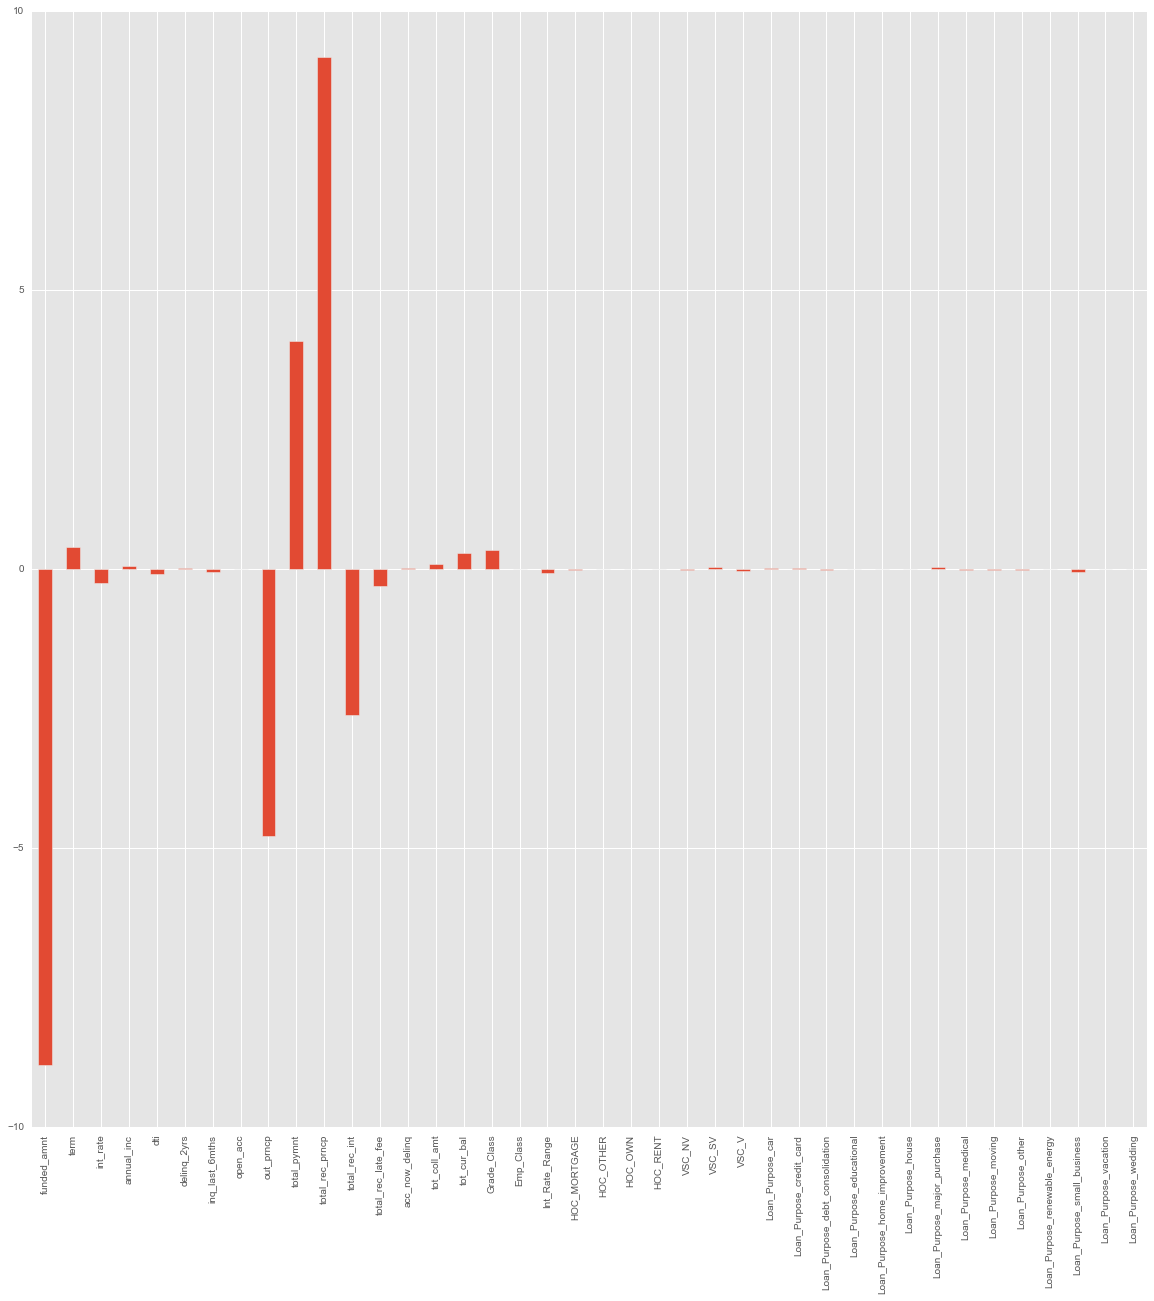

In [26]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))

weights = pd.Series(lr_clf.coef_[0],index=loan_df_Historical.columns)
weights.plot(kind='bar')
plt.show()